# scRNA-seq analysis using Scanpy (prepare for SCENIC+)

In [39]:
import warnings
warnings.simplefilter(action = 'ignore', category=FutureWarning)
import sys
import os
_stderr = sys.stderr
null = open(os.devnull, 'wb')
work_dir = 'BS1140'

In [42]:
import scanpy as sc
#set some figure parameters for nice display inside jupyternotebooks.
%matplotlib inline
sc.settings.set_figure_params(dpi=80, frameon=False, figsize=(5, 5), facecolor='white')

# make a directory to store the processed scRNA-seq data
if not os.path.exists(os.path.join(work_dir,'scRNA')):
    os.makedirs(os.path.join(work_dir,'scRNA'))

In [43]:
# read in the scRNA-seq count matrix into AnnData object
adata = sc.read_10x_h5(os.path.join(work_dir, '/Users/jinhuixin/Master/thesis/aligned_raw_data/BS1140/outs/filtered_feature_bc_matrix.h5'))
adata.var_names_make_unique()
adata

/Users/jinhuixin/miniconda3/envs/scenicplus/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 2958 × 36601
    var: 'gene_ids', 'feature_types', 'genome'

remove TCR BCR

In [45]:
import numpy as np
TCRBCR_genes = adata.var_names.str.startswith(('TRAV', 'TRAJ', 'TRBV', 'TRBD', 'TRBJ'))
keep = np.invert(TCRBCR_genes)
adata = adata[:,keep]


remove doublets

In [48]:
sc.external.pp.scrublet(adata) #estimates doublets
adata = adata[adata.obs['predicted_doublet'] == False] #do the actual filtering
adata

/Users/jinhuixin/miniconda3/envs/scenicplus/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.47
Detected doublet rate = 0.2%
Estimated detectable doublet fraction = 12.0%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 1.7%


### Filter

In [ ]:
# basic filter
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

/Users/jinhuixin/miniconda3/envs/scenicplus/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number


/var/folders/73/t_19bmpd5m7bnvd_88sxp6lw0000gn/T/ipykernel_60909/2894892676.py:2: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['mt'] = adata.var_names.str.startswith('MT-') # annotate the group of mitochondrial genes as mt


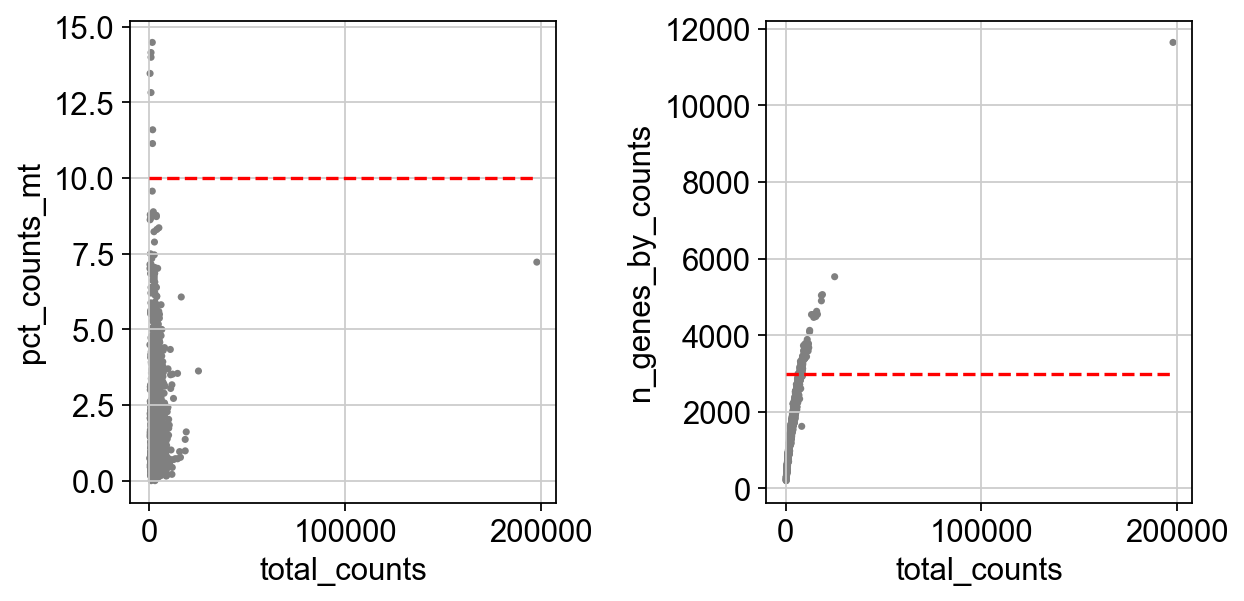

In [50]:
# filter based on mitochondrial counts and total counts
adata.var['mt'] = adata.var_names.str.startswith('MT-') # annotate the group of mitochondrial genes as mt
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
import matplotlib.pyplot as plt
mito_filter = 10
n_counts_filter_max = 3000 # same as seurat parameter
n_counts_filter_min = 150 # same as seurat parameter
fig, axs = plt.subplots(ncols=2, figsize = (8,4))
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt', ax=axs[0], show=False)
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts', ax = axs[1], show = False)
# draw horizontal red lines indicating thresholds
axs[0].hlines(y = mito_filter, xmin = 0, xmax = max(adata.obs['total_counts']), color='red',ls='dashed')
axs[1].hlines(y = n_counts_filter_max, xmin = 0, xmax = max(adata.obs['total_counts']), color = 'red', ls = 'dashed')
fig.tight_layout()
plt.show()

In [51]:
adata = adata[(adata.obs.n_genes_by_counts > n_counts_filter_min) &  (adata.obs.n_genes_by_counts < n_counts_filter_max), :]
adata = adata[adata.obs.pct_counts_mt < mito_filter, :]
adata

View of AnnData object with n_obs × n_vars = 2834 × 19979
    obs: 'n_genes', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'scrublet'

### Normalization

/Users/jinhuixin/miniconda3/envs/scenicplus/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


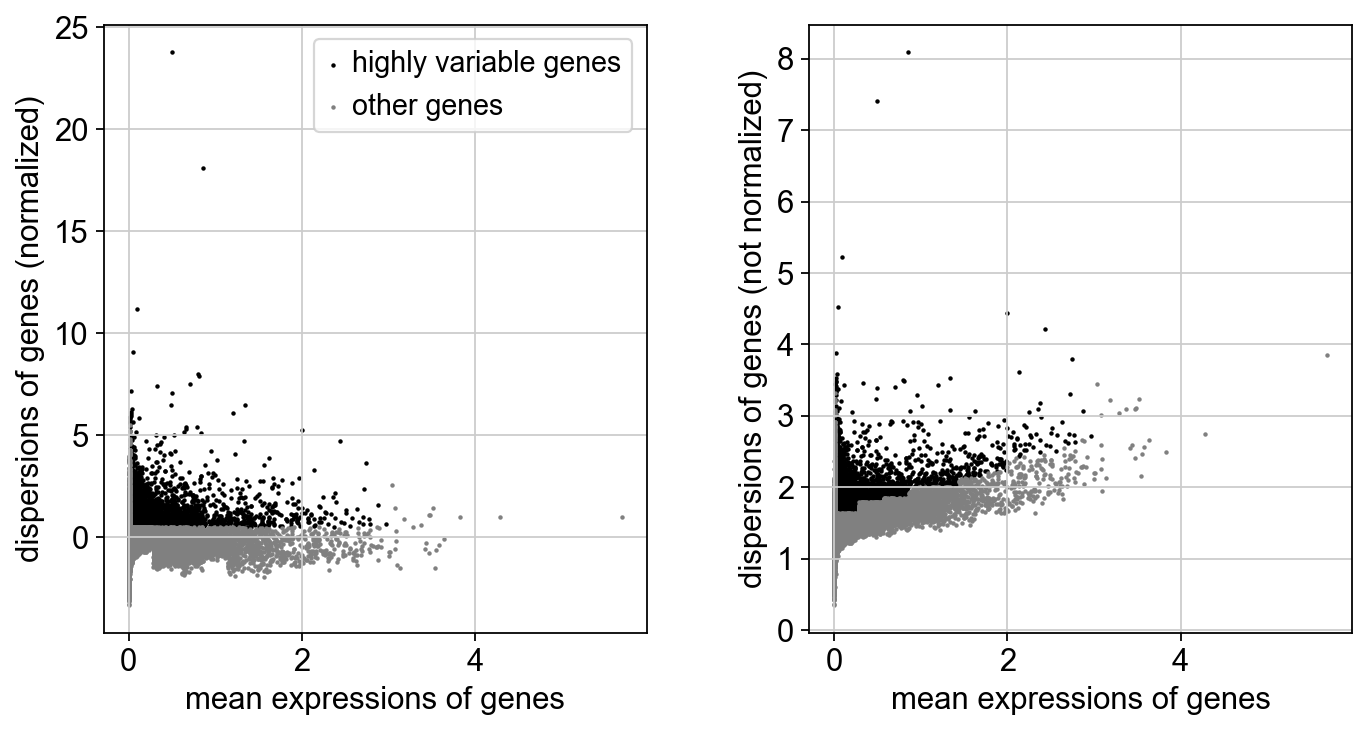

In [52]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata)
adata.raw = adata
#adata = adata[:, adata.var.highly_variable]
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(adata, max_value=10)

### Cell type annotation

These annotation will be used in pycisTopic to generate pseudobulk ATAC profiles and call peaks.
The annotations are different with the seurat results.

adata_ref = sc.datasets.pbmc3k_processed() #use the preprocessed data from the Scanpy tutorial as reference
var_names = adata_ref.var_names.intersection(adata.var_names) #use genes which arepresent in both assays
adata_ref = adata_ref[:, var_names]
adata = adata[:, var_names]
sc.pp.pca(adata_ref) # calculate PCA embedding
sc.pp.neighbors(adata_ref) # calculate neighborhood graph
sc.tl.umap(adata_ref)
sc.tl.ingest(adata, adata_ref, obs='louvain') # run label transfer
adata.obs.rename({'louvain':'ingest_celltype_label'}, inplace = True, axis = 1)

In [ ]:
sc.tl.pca(adata, svd_solver='arpack')
# computing the neighborhood graph
sc.pp.neighbors(adata, n_neighbors=20, n_pcs=50)
sc.tl.umap(adata)

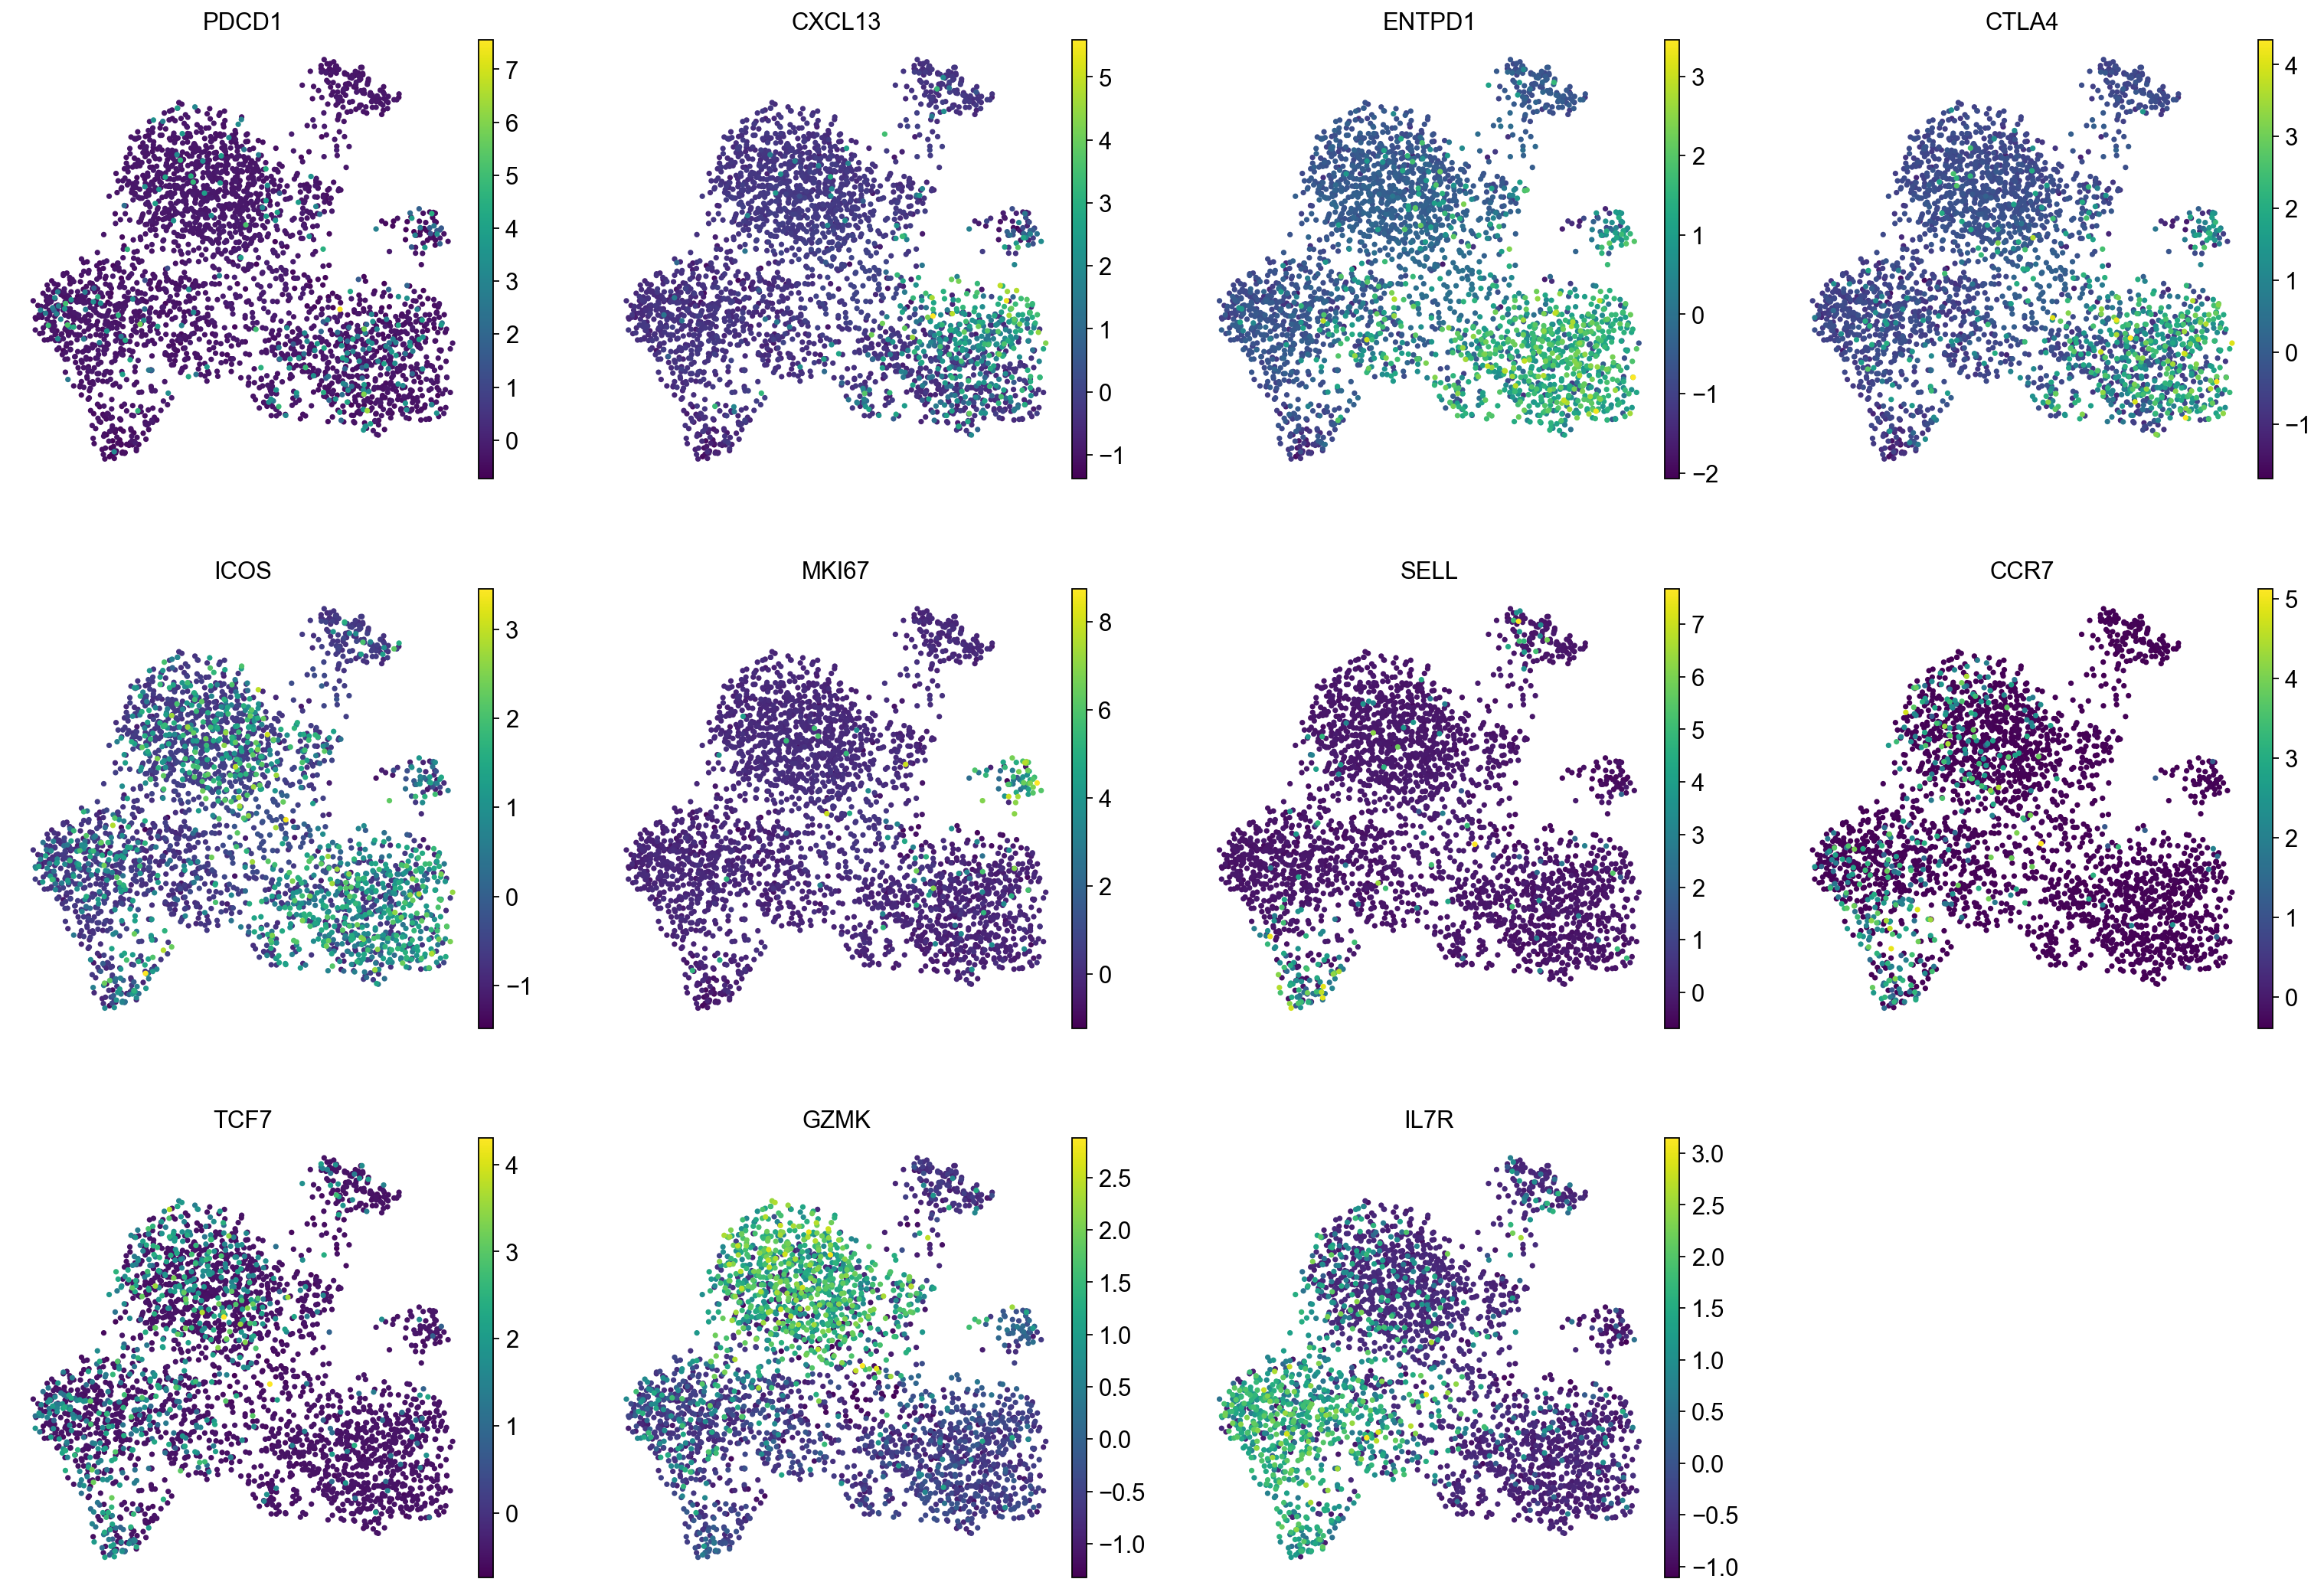

In [57]:
markerGenes = ["PDCD1", "CXCL13", "ENTPD1", "CTLA4", # exhausted T cells
                "ICOS", "MKI67", # proliferate
                "SELL", "CCR7", "TCF7", # naive T cells
                "GZMK", # pre-dysfunctional T cell
                "IL7R"] # memory 
# use scaled and corrected gene expression
sc.pl.umap(adata, color = markerGenes, use_raw = False)

#### Clustering (Leiden graph-clustering method)

clean the annotation a bit by running a clustering and assigning clusters to cell types based on maximum overlap

/Users/jinhuixin/miniconda3/envs/scenicplus/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


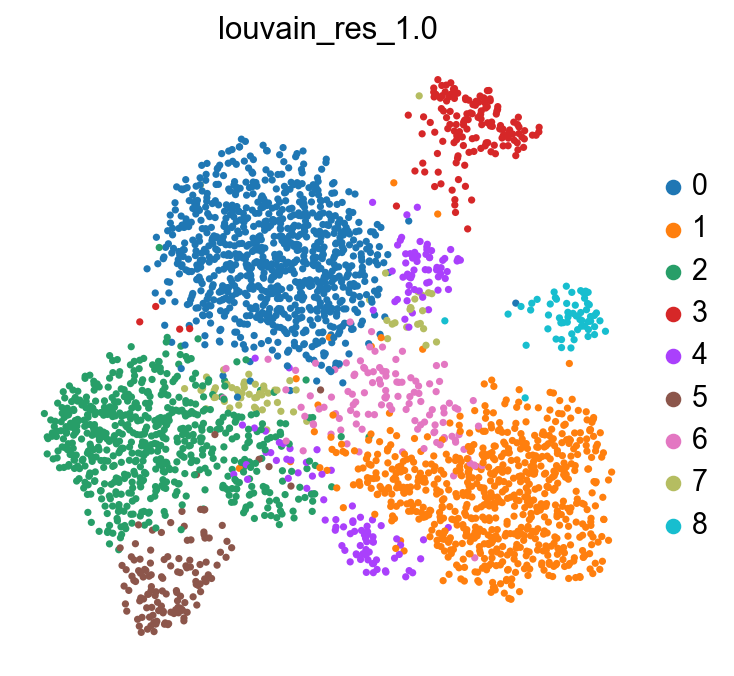

In [58]:
# default clustering method of seurat is louvain
sc.tl.louvain(adata, resolution=1, key_added='louvain_res_1.0')
sc.pl.umap(adata, color = 'louvain_res_1.0')

#### Finding marker genes

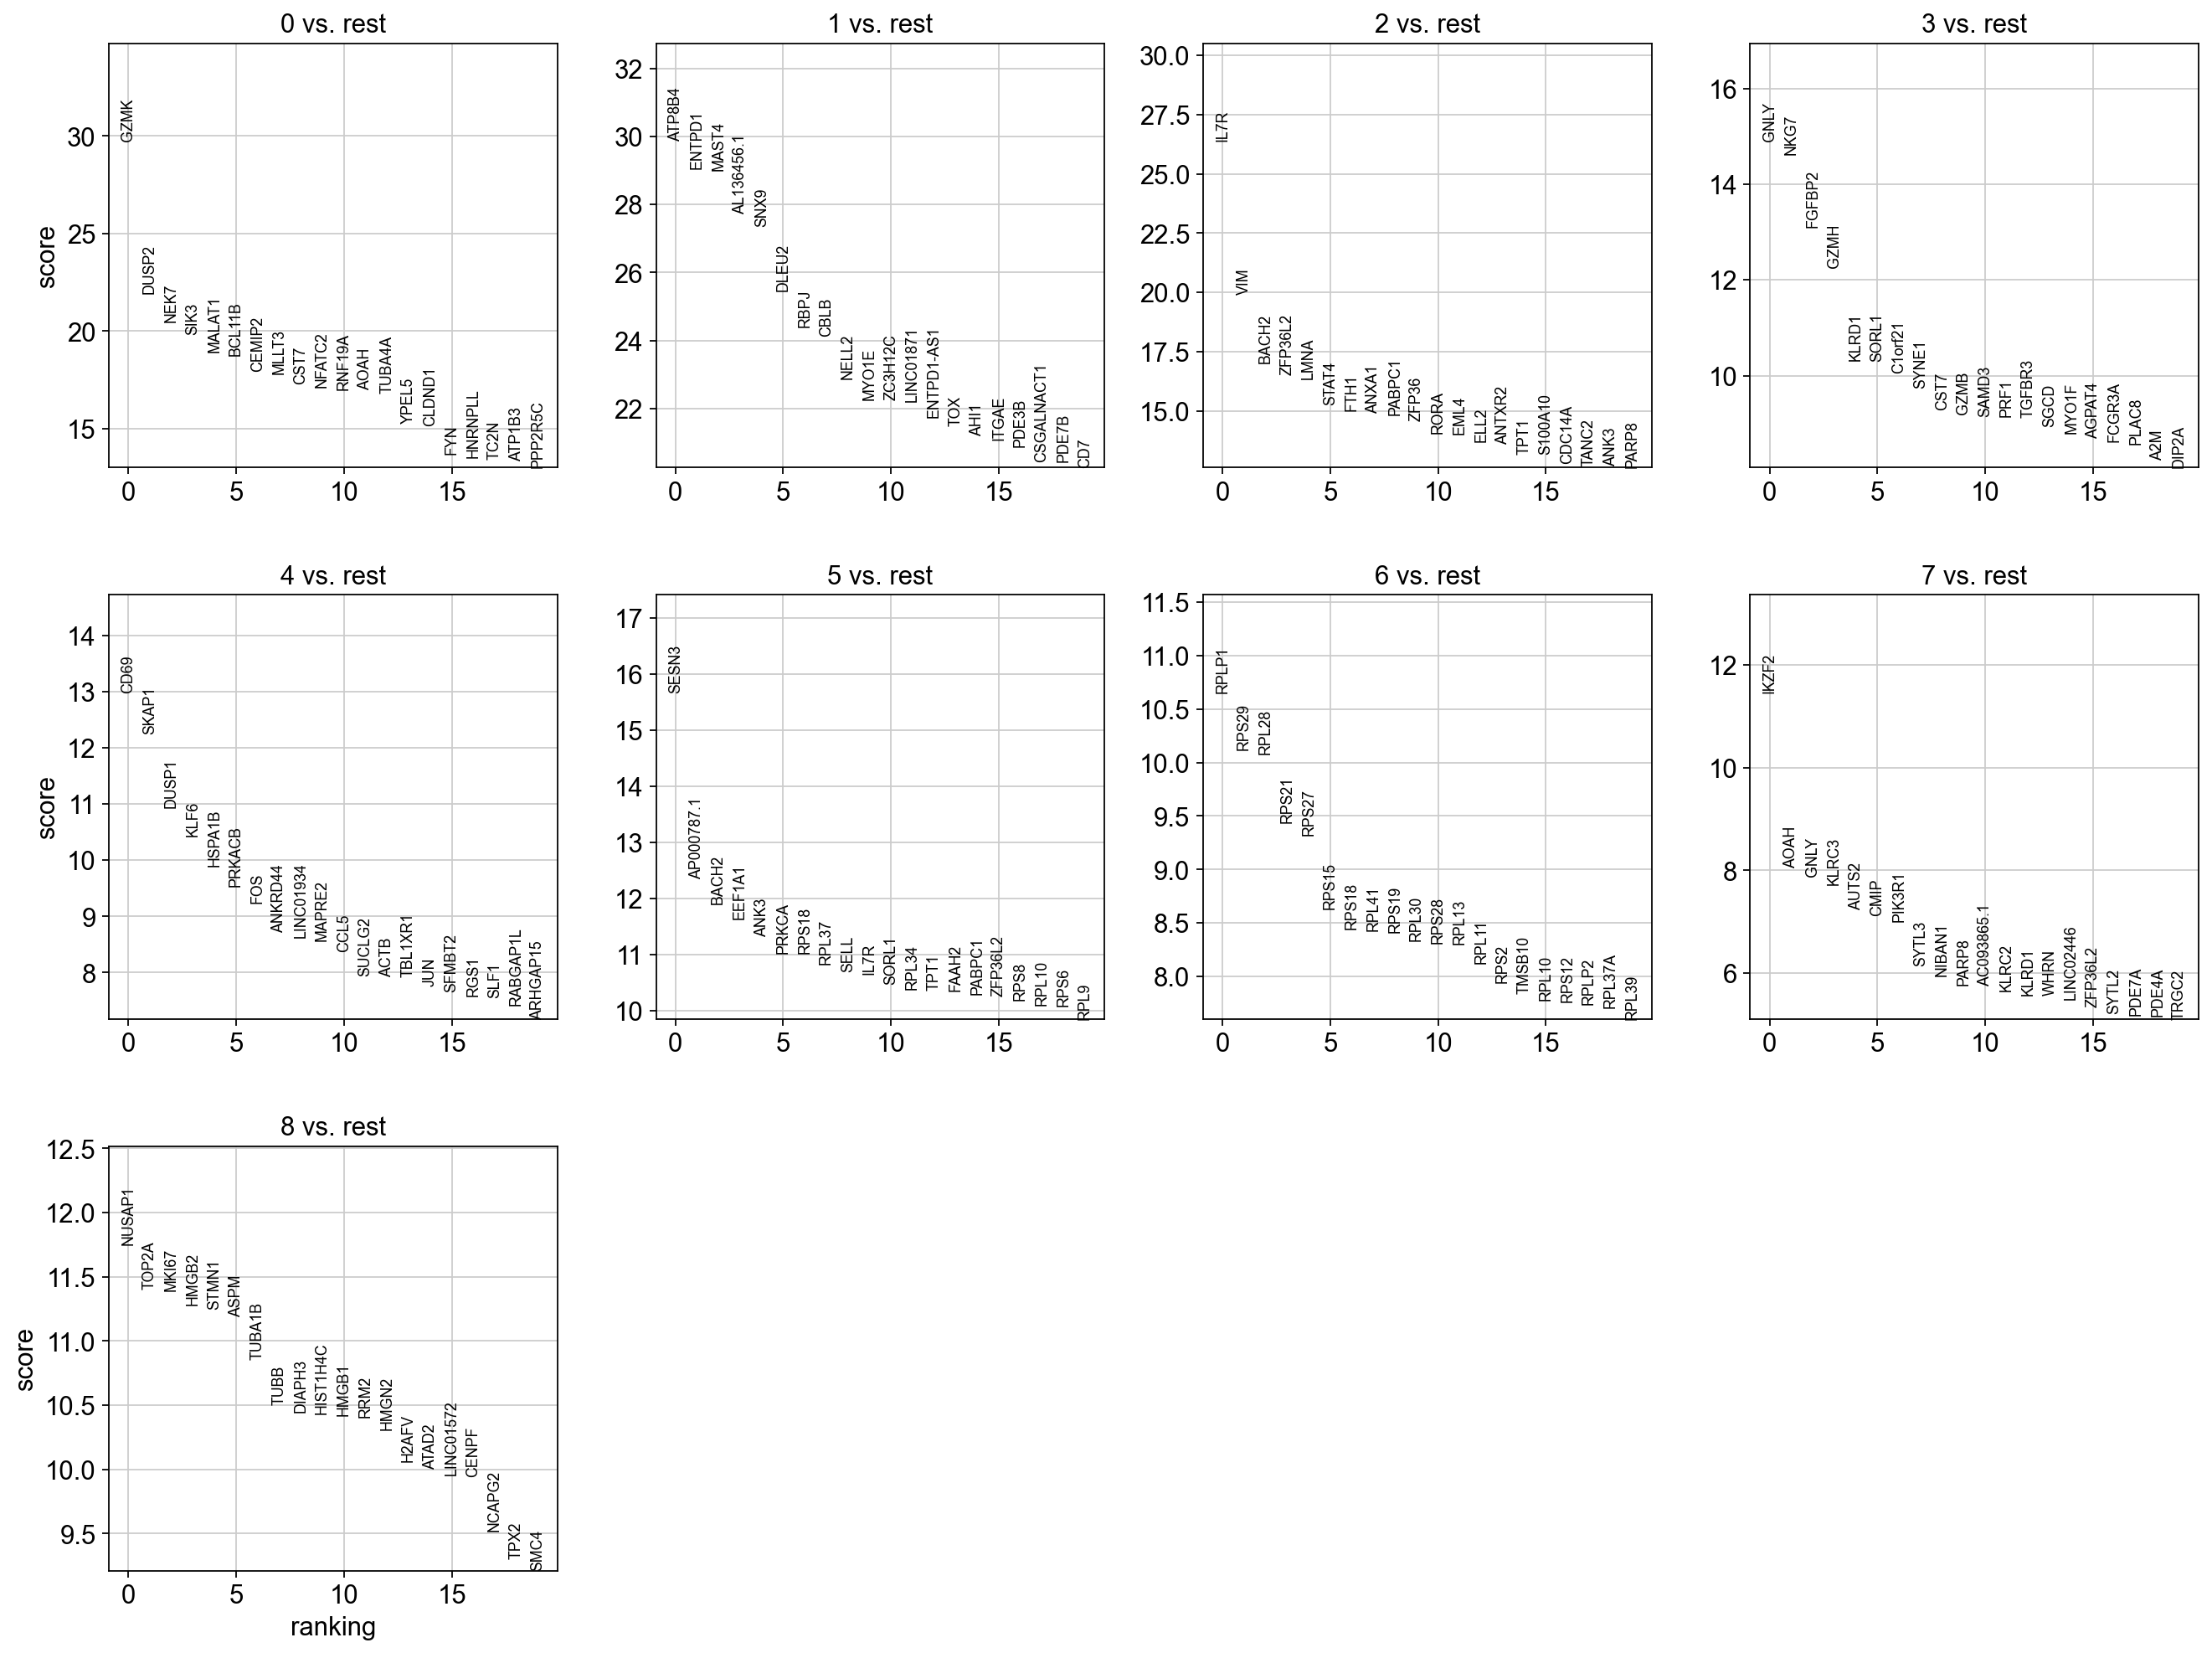

In [59]:
# highly differential genes in each cluster
sc.tl.rank_genes_groups(adata, 'louvain_res_1.0', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False)

In [60]:
# top 10 genes per cluster
import pandas as pd
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(10)

0           1        2        3          4           5      6       7  \
0    GZMK      ATP8B4     IL7R     GNLY       CD69       SESN3  RPLP1   IKZF2   
1   DUSP2      ENTPD1      VIM     NKG7      SKAP1  AP000787.1  RPS29    AOAH   
2    NEK7       MAST4    BACH2   FGFBP2      DUSP1       BACH2  RPL28    GNLY   
3    SIK3  AL136456.1  ZFP36L2     GZMH       KLF6      EEF1A1  RPS21   KLRC3   
4  MALAT1        SNX9     LMNA    KLRD1     HSPA1B        ANK3  RPS27   AUTS2   
5  BCL11B       DLEU2    STAT4    SORL1     PRKACB       PRKCA  RPS15    CMIP   
6  CEMIP2        RBPJ     FTH1  C1orf21        FOS       RPS18  RPS18  PIK3R1   
7   MLLT3        CBLB    ANXA1    SYNE1    ANKRD44       RPL37  RPL41   SYTL3   
8    CST7       NELL2   PABPC1     CST7  LINC01934        SELL  RPS19  NIBAN1   
9  NFATC2       MYO1E    ZFP36     GZMB     MAPRE2        IL7R  RPL30   PARP8   

          8  
0    NUSAP1  
1     TOP2A  
2     MKI67  
3     HMGB2  
4     STMN1  
5      ASPM  
6    TUBA1B  
7      TUBB  
8    DIAPH3  
9  HIST1H4C

Louvain Group |Markers |Cell Type
-----|-----|----- 
0|GZMK|M-GZMK+
1|ENTPD1|Ex
2|IL7R|M-IL7R+
3|GNLY, NKG7|GNLY+NKG7+
4|CD69|M-CD69+
5|SELL|Naive
6|RPLP1|RPLP1+
7|IKZF2, AOAH|IKZF2+AOAH+
8|MKI67|Ex-MKI67+

In [61]:
marker_genes = ['GZMK', 'ENTPD1','IL7R','GNLY','NKG7','CD69','SELL','RPLP1','IKZF2','AOAH','MKI67']

### cell type

/Users/jinhuixin/miniconda3/envs/scenicplus/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


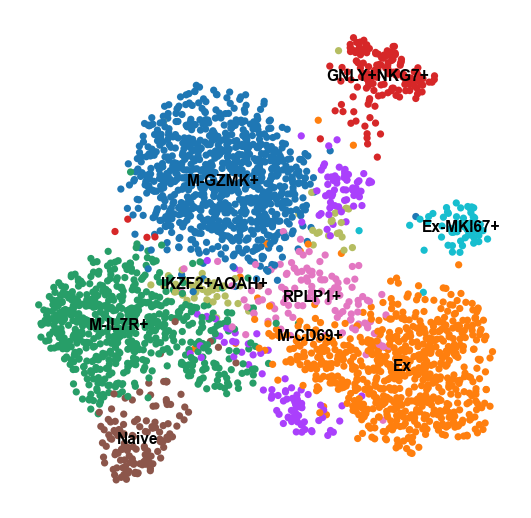

In [62]:
from turtle import color, title

new_cluster_names = ['M-GZMK+','Ex','M-IL7R+','GNLY+NKG7+','M-CD69+','Naive','RPLP1+','IKZF2+AOAH+', 'Ex-MKI67+']
adata.rename_categories('louvain_res_1.0', new_cluster_names)
sc.set_figure_params(scanpy=True, fontsize=7)
sc.pl.umap(adata, color = 'louvain_res_1.0', legend_loc='on data', title='', frameon=False, save='-cell-type')

/Users/jinhuixin/miniconda3/envs/scenicplus/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


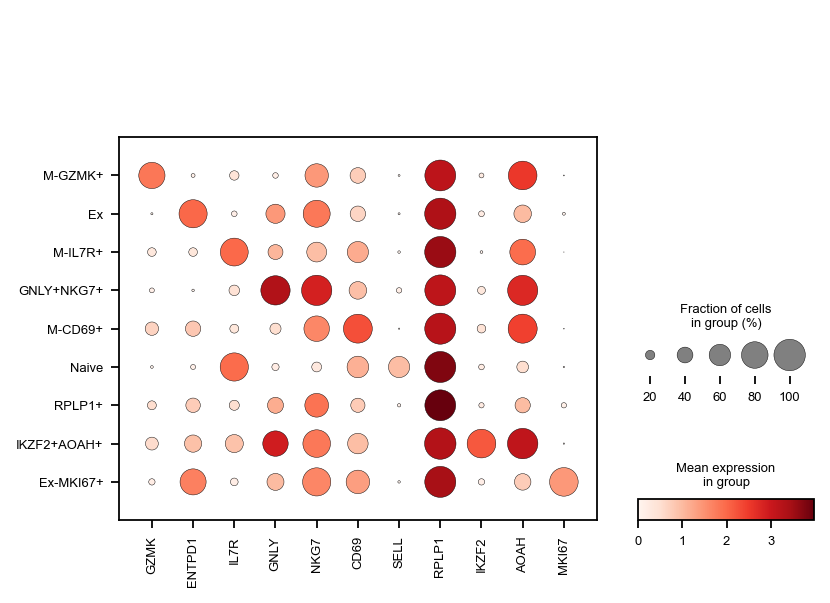

In [63]:
sc.pl.dotplot(adata, marker_genes, groupby='louvain_res_1.0')

In [65]:
adata.obs['celltype'] = adata.obs['louvain_res_1.0']
adata.obs

n_genes  doublet_score  predicted_doublet  \
AAACAGCCACACAATT-1     1578       0.076549              False   
AAACATGCAACTAGAA-1     2174       0.042276              False   
AAACCAACACAGCCAT-1     1429       0.028834              False   
AAACCGAAGGCTAATC-1     1067       0.076549              False   
AAACCGGCACAAACTT-1     1862       0.040253              False   
...                     ...            ...                ...   
TTTGTGAAGTGTTGTA-1      928       0.034833              False   
TTTGTGTTCACATTGA-1     2816       0.197889              False   
TTTGTTGGTGTTTGTC-1     1469       0.197889              False   
TTTGTTGGTTAGAGGG-1     1563       0.060762              False   
TTTGTTGGTTTAGTCC-1     2086       0.060762              False   

                    n_genes_by_counts  total_counts  total_counts_mt  \
AAACAGCCACACAATT-1               1575        3029.0             89.0   
AAACATGCAACTAGAA-1               2172        4981.0             43.0   
AAACCAACACAGCCAT-1               1427        3007.0             21.0   
AAACCGAAGGCTAATC-1               1066        1681.0             63.0   
AAACCGGCACAAACTT-1               1860        3879.0              9.0   
...                               ...           ...              ...   
TTTGTGAAGTGTTGTA-1                926        1552.0              4.0   
TTTGTGTTCACATTGA-1               2811        7312.0             25.0   
TTTGTTGGTGTTTGTC-1               1468        2862.0             25.0   
TTTGTTGGTTAGAGGG-1               1561        2644.0             95.0   
TTTGTTGGTTTAGTCC-1               2086        4785.0             47.0   

                    pct_counts_mt louvain_res_1.0 celltype  
AAACAGCCACACAATT-1       2.938263         M-GZMK+  M-GZMK+  
AAACATGCAACTAGAA-1       0.863280              Ex       Ex  
AAACCAACACAGCCAT-1       0.698370         M-IL7R+  M-IL7R+  
AAACCGAAGGCTAATC-1       3.747769         M-GZMK+  M-GZMK+  
AAACCGGCACAAACTT-1       0.232019              Ex       Ex  
...                           ...             ...      ...  
TTTGTGAAGTGTTGTA-1       0.257732         M-GZMK+  M-GZMK+  
TTTGTGTTCACATTGA-1       0.341904          RPLP1+   RPLP1+  
TTTGTTGGTGTTTGTC-1       0.873515              Ex       Ex  
TTTGTTGGTTAGAGGG-1       3.593041              Ex       Ex  
TTTGTTGGTTTAGTCC-1       0.982236              Ex       Ex  

[2834 rows x 9 columns]

/Users/jinhuixin/miniconda3/envs/scenicplus/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


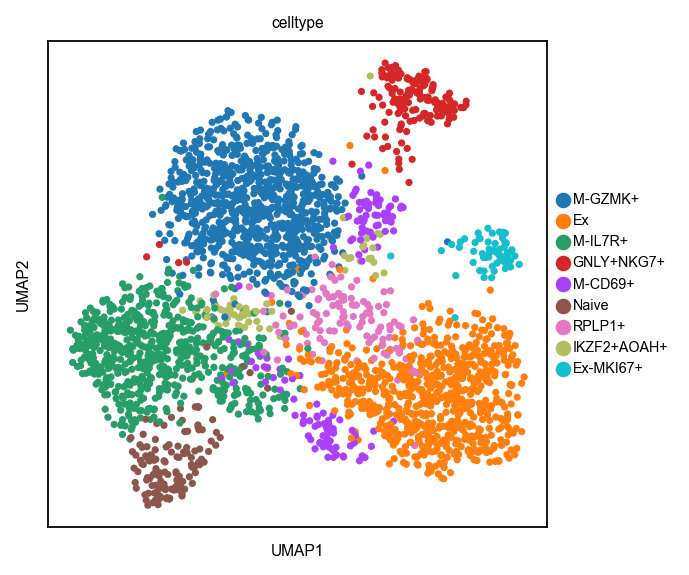

In [66]:
sc.pl.umap(adata, color = 'celltype')

In [67]:
# save result
adata.write(os.path.join(work_dir, 'scRNA/adata.h5ad'), compression='gzip')